# Neural Network

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from ipywidgets import interact, IntSlider, interactive
import seaborn as sns;
import sys

## Training a Neural Network
Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). It looks something like this:

<img src='./nn-3-layer-network.png' style='width: 50%'/>

We can choose the dimensionality (the number of nodes) of the hidden layer. The more nodes we put into the hidden layer the more complex functions we will be able fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data. 

How to choose the size of the hidden layer? While there are some general guidelines and recommendations, it always depends on your specific problem and is more of an art than a science. We will play with the number of nodes in the hidden later later on and see how it affects our output.

We also need to pick an *activation function* for our hidden layer. The activation function transforms the inputs of the layer into its outputs. A nonlinear activation function is what allows us to fit nonlinear hypotheses. Common chocies for activation functions are [tanh](https://reference.wolfram.com/language/ref/Tanh.html), the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), or [ReLUs](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). We will use `tanh`, which performs quite well in many scenarios. A nice property of these functions is that their derivate can be computed using the original function value. For example, the derivative of $\tanh x$ is $1-\tanh^2 x$. This is useful because it allows us to compute $\tanh x$ once and re-use its value later on to get the derivative.

Because we want our network to output probabilities the activation function for the output layer will be the [softmax](https://en.wikipedia.org/wiki/Softmax_function), which is simply a way to convert raw scores to probabilities. If you're familiar with the logistic function you can think of softmax as its generalization to multiple classes.

### How Neural Network Makes Predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the input of layer $i$ and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}

The formula looks complicated, but all it really does is sum over our training examples and add to the loss if we predicted the incorrect class. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be. 

Remember that our goal is to find the parameters that minimize our loss function. We can use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. I will implement the most vanilla version of gradient descent, also called batch gradient descent with a fixed learning rate. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. So if you are serious you'll want to use one of these, and ideally you would also [decay the learning rate over time](http://cs231n.github.io/neural-networks-3/#anneal).

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. To calculate these gradients we use the famous *backpropagation algorithm*, which is a way to efficiently calculate the gradients starting from the output. I won't go into detail how backpropagation works, but there are many excellent explanations ([here](http://colah.github.io/posts/2015-08-Backprop/) or [here](http://cs231n.github.io/optimization-2/)) floating around the web.

Applying the backpropagation formula we find the following (trust me on this):

\begin{aligned}
\delta_3 &= \hat{y} - y \\
\delta_2 &= (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
\frac{\partial{L}}{\partial{W_2}} &= a_1^T \delta_3  \\
\frac{\partial{L}}{\partial{b_2}} &= \delta_3\\
\frac{\partial{L}}{\partial{W_1}} &= x^T \delta_2\\
\frac{\partial{L}}{\partial{b_1}} &= \delta_2 \\
\end{aligned}

## Some Necessary Functions for Visualisation and Other Stuff

In [2]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, bias=0):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        bias_node = (bias if n<len(layer_sizes)-1 else 0)
        for m in range(layer_size+bias_node ):
            node_color = 'w' if m<layer_size else 'b'
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color=node_color, ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a+bias):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], 
                                  c='k')
                ax.add_artist(line)
                
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('white')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'red' if w > 0 else 'blue'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    
# Plots the desicion boundary for classification problems
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=plt.cm.Spectral)
    
# Plots the functions for the learning the functions problem
def plot_function(pred_func, X, y):
    x_min, x_max = X.min() - .5, X.max() + .5
    y_min, y_max = y.min() - .5, y.max() + .5
    
    xx = np.arange(x_min, x_max, 0.1)
    xx = xx.reshape(len(xx),1)
    yy = pred_func(xx)
    plt.plot(xx, yy,'r.')
    plt.plot(X, y, 'g.')
    
# Calculates the accuracy for the 
def accuracy(predictions, labels ,output_mode):
    if output_mode == "Softmax":
        preds_correct_boolean = np.argmax(predictions, 1) == np.argmax(labels, 1)
    if output_mode == "Sigmoid":
        preds_correct_boolean = np.round(predictions) == np.round(labels)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy

# Selects which input and corresponding output node activation function will be used
def select_input(decision):
    if decision == "xor":
        X, X_test, y, y_test = xor()
        output_mode = 'Sigmoid'
    if decision == "inverse_function":
        X, X_test, y, y_test = inverse_function()
        output_mode = 'Linear'
    if decision == "gaussian_mixture":
        X, X_test, y, y_test = gaussian_mixture()
        output_mode = 'Softmax'
    if decision == "make_moons":
        X, X_test, y, y_test = make_moons()
        output_mode = 'Sigmoid'    
    return X, X_test, y, y_test, output_mode

# Inputs

One should run one of the below datasets. 

### X-OR Example

This is binary classification problem and requires sigmoid at the output.

In [3]:
def xor():
    X_all = np.array([  
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]])

    y_all = np.array([[0, 1, 1, 0]]).T

    X = X_all
    X_test = X_all
    y = y_all
    y_test = y_all
    print ("The Actual Dataset for X-Or")
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], s = 500, c=y.flat, cmap=plt.cm.Spectral)
    plt.colorbar()
    plt.show()
    return X, X_test, y, y_test

### $Y = 1/X$ Example

This is linear example and requires linear output unit.

In [4]:
def inverse_function():
    X_all = np.arange(1,101).reshape(100,1)
    #y_all = 1/X_all
    y_all = 10*np.sin(X_all/10)
    X, X_test, y, y_test = train_test_split(X_all, y_all, test_size = .1, random_state = 12)
    print ("The Actual Dataset for y=1/X")
    plt.figure(figsize=(15,5))
    plt.plot(X_all,y_all)
    plt.show()
    return X, X_test, y, y_test

### Gaussian Mixtures Example

This is multiple class example and requires softmax at the output.

In [5]:
def gaussian_mixture():
    np.random.seed(12)
    num_observations = 5000

    x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
    x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
    x3 = np.random.multivariate_normal([2, 8], [[0, .75],[.75, 0]], num_observations)

    X_all = np.vstack((x1, x2, x3)).astype(np.float32)
    y_all = np.hstack((np.zeros(num_observations),
                       np.ones(num_observations), np.ones(num_observations) + 1))

    labels_onehot = np.zeros((y_all.shape[0], 3)).astype(int)
    labels_onehot[np.arange(len(y_all)), y_all.astype(int)] = 1

    X, X_test, y, y_test = train_test_split(X_all, labels_onehot, test_size = .1, random_state = 12)
    print ("The Actual Dataset for Gaussian Mixture")
    plt.figure(figsize=(15,5))
    plt.scatter(X_all[:, 0], X_all[:, 1], c = y_all, alpha = .4)
    plt.show()
    return X, X_test, y, y_test

### Scikit_Learn Make Moons Function
This is again two class function.

In [6]:
def make_moons():
    np.random.seed(0)
    X_all, y_all = datasets.make_moons(2000, noise=0.1)
    print ("The Actual Dataset for Make Moons Function")
    plt.figure(figsize=(15,5))
    plt.scatter(X_all[:,0], X_all[:,1], s=40, c=y_all, cmap=plt.cm.Spectral)
    plt.show()
    y_all = y_all.reshape(len(y_all),1)
    X, X_test, y, y_test = train_test_split(X_all, y_all, test_size = .1, random_state = 12)
    return X, X_test, y, y_test

# Functions for Neural Network

In [7]:
def activation(x, mode):
    if mode == "Tangent":
        return np.tanh(x)
    if mode == "Sigmoid":
        return 1.0 / (1.0 + np.exp(-x))
    if mode == "Softplus":
        return np.log(1.0 + np.exp(x))
    if mode == "Relu":
        return x * (x > 0)
    if mode == "Linear":
        return x
    if mode == "Softmax":
        logits_exp = np.exp(x - x.max())
        return logits_exp / np.sum(logits_exp, axis = 1, keepdims = True)

def activation_prime(x, mode):
    if mode == "Tangent":
        return 1.0 / (np.cosh(x) ** 2)
    if mode == "Sigmoid":
        return (1.0 / (1.0 + np.exp(-x))) * (np.exp(-x) / (1.0 + np.exp(-x)))
    if mode == "Softplus":
        return 1.0 / (1.0 + np.exp(-x))
    if mode == "Relu":
        return 1.0 * (x > 0)
    if mode == "Linear":
        return 1.0
    if mode == "Softmax":
        logits_exp = np.exp(x - x.max())
        softmax = logits_exp / np.sum(logits_exp, axis = 1, keepdims = True)
        return softmax * (1 - softmax)
    
def loss_function(y, y_prime, mode):
    if mode == "Sigmoid":
        return np.average(- y * np.log(y_prime) - (1.0 - y) * np.log(1.0 - y_prime))
    if mode == "Linear":
        return np.average((1.0 / 2.0) * (y - y_prime) ** 2)
    if mode == "Softmax":
        indices = np.argmax(y, axis = 1).astype(int)
        predicted_probability = y_prime[np.arange(len(y_prime)), indices]
        return np.average(- np.log(predicted_probability))

def regularization(lambda_reg, weights):
    weight_loss = 0
    for i in range(len(weights)):
        weight_loss = weight_loss + 0.5 * lambda_reg * np.sum(weights[i] * weights[i])
    return weight_loss

def forward_propagation(X, depth, weights, hidden_mode, output_mode):
    layers = [None] * depth
    layers[0] = np.hstack((np.ones((X.shape[0], 1)), X))
    for j in range(depth - 1):
        if j != depth - 2:
            layers[j + 1] = np.hstack((np.ones((layers[j].shape[0], 1)), activation(np.dot(layers[j], weights[j]), hidden_mode)))
        else:
            layers[j + 1] = activation(np.dot(layers[j], weights[j]), output_mode)
    return layers

def back_propagation(y, depth, weights, hidden_mode, layers, lambda_reg):
    gradients = [None] * (depth - 1)
    for k in reversed(range(1, depth)):
        if k == depth - 1:
            error = layers[k] - y
        else:
            error = activation_prime(layers[k][:, 1:], hidden_mode) * np.dot(error, weights[k].T[:, 1:])
            
        gradients[k - 1] = np.average(layers[k - 1][:, :, np.newaxis] * error[:, np.newaxis, :], axis = 0)
        gradients[k - 1] = gradients[k - 1] + lambda_reg * weights[k - 1]
    return gradients

def training(X, y, BATCH_SIZE, max_epoch, network_shape, depth, l_rate,lambda_reg, momentum, hidden_mode, output_mode):
    loss_list = []
    weights = []
    delta = []
    for i in range(depth - 1):
        weights.append(np.random.rand(network_shape[i] + 1, network_shape[i + 1]))
        delta.append(np.zeros((network_shape[i] + 1, network_shape[i + 1])))
        
    for epoch in range(max_epoch):
        index = np.random.choice(X.shape[0], BATCH_SIZE, replace=False)
        X_batch = X[index]
        y_batch = y[index]
        layers = forward_propagation(X_batch, depth, weights, hidden_mode, output_mode)
        gradients = back_propagation(y_batch, depth, weights, hidden_mode, layers, lambda_reg)
        
        for l in range(depth - 1):
            delta[l] = momentum * delta[l] - l_rate * gradients[l]
            weights[l] += delta[l]
        
        full_layers = forward_propagation(X, depth, weights, hidden_mode, output_mode)
        loss = loss_function(y, full_layers[depth - 1], output_mode) + regularization(lambda_reg, weights)
        loss_list.append(loss)
        if epoch % 500 == 0:
            print (epoch, loss)
        if loss < 10e-3:
            print (epoch, loss)
            break

    return weights, loss_list

# Parameters of Neural Network

The Actual Dataset for Make Moons Function


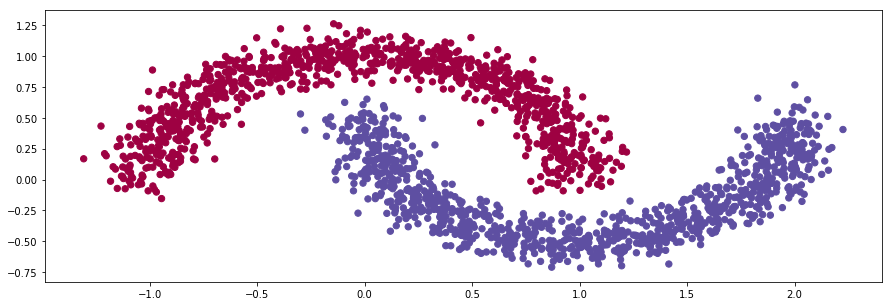

In [17]:
X, X_test, y, y_test, output_mode = select_input("make_moons")
hidden_mode = 'Tangent'
l_rate = 0.0005 #Use 0.005 for Tangent and Sigmoid, use 0.0005 for Softplus, use 0.0001 for Relu
lambda_reg = 0.1
momentum = 0.99
network_shape = np.array([X.shape[1], 25,50, y.shape[1]])
depth = len(network_shape)
max_epoch = 5000

BATCH_SIZE = 1
if BATCH_SIZE > X.shape[0]:
    BATCH_SIZE = X.shape[0]

0 36.579865386340295
500 0.8234719903040318
1000 0.6157566540672132
1500 0.596500416072105
2000 0.604579425859858
2500 0.6229211875365572
3000 0.5992317960877922
3500 0.5991492232540689
4000 0.6087083613299125
4500 0.6031757191874441


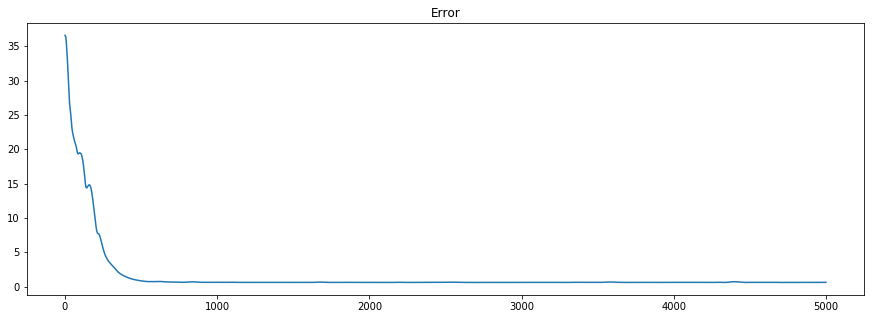

The shape and magnitudes of weights of hidden layer 0
(3, 25)


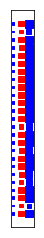

The shape and magnitudes of weights of hidden layer 1
(26, 50)


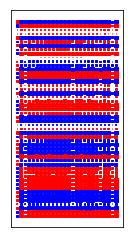

The shape and magnitudes of weights of hidden layer 2
(51, 1)


The Neural Network


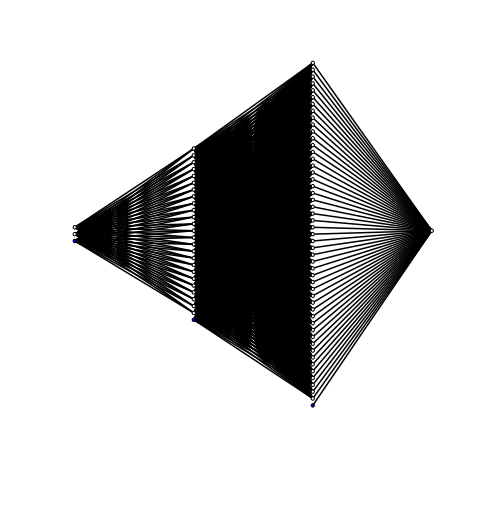

In [18]:
np.random.seed(1)
weights, loss = training(X, y, BATCH_SIZE, max_epoch, network_shape, depth, 
                         l_rate, lambda_reg, momentum, hidden_mode, output_mode)

layer = forward_propagation(X_test, depth, weights, hidden_mode, output_mode)

fig = plt.figure(figsize=(15,5))
plt.plot(loss)
plt.title("Error")
plt.show()

for i in range(len(weights)):
    print ("The shape and magnitudes of weights of hidden layer "+str(i))
    print (weights[i].shape)
    hinton(weights[i])
    plt.show()
    
print ("The Neural Network")
fig = plt.figure(figsize=(8, 9))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, 0.1, .9, .2, .9, network_shape, bias=1)

### Calculate The Accuracy

In [19]:
if output_mode != "Linear":
    print ('Test accuracy: {0}%'.format(accuracy(layer[depth - 1], y_test, output_mode)))
else:
    print ("This is not a classification problem")

Test accuracy: 85.5%


### Compare The Desired Values and The Results

In [20]:
for i in range(len(y_test)):
    print (layer[depth - 1][i], y_test[i])

[0.72227555] [1]
[0.09955551] [0]
[0.55870579] [1]
[0.10986646] [0]
[0.75970713] [1]
[0.09584849] [0]
[0.52836992] [1]
[0.15420376] [0]
[0.29040445] [0]
[0.7774778] [1]
[0.31614754] [1]
[0.22924278] [0]
[0.51940963] [1]
[0.55510812] [0]
[0.39602892] [1]
[0.18329132] [0]
[0.44847455] [1]
[0.70031351] [1]
[0.08641523] [0]
[0.33582642] [1]
[0.39222177] [0]
[0.19835452] [0]
[0.68839509] [1]
[0.74245034] [1]
[0.43728335] [0]
[0.33275299] [0]
[0.66888054] [1]
[0.4040178] [0]
[0.12225495] [0]
[0.08455154] [0]
[0.16172985] [0]
[0.1404747] [0]
[0.13902976] [0]
[0.17972349] [0]
[0.21801146] [0]
[0.61814582] [1]
[0.42320862] [0]
[0.09112544] [0]
[0.16772653] [0]
[0.09791395] [0]
[0.78489186] [1]
[0.63548153] [1]
[0.57109779] [1]
[0.22755646] [0]
[0.80151107] [1]
[0.10211933] [0]
[0.10272344] [0]
[0.13840133] [0]
[0.33133338] [1]
[0.1068213] [0]
[0.20431812] [0]
[0.74978547] [1]
[0.44372733] [0]
[0.30999652] [1]
[0.71316413] [1]
[0.51865185] [1]
[0.44992232] [0]
[0.63959746] [1]
[0.54811778] [1]
[

### Plot the Decision Boundary for Classification Problems

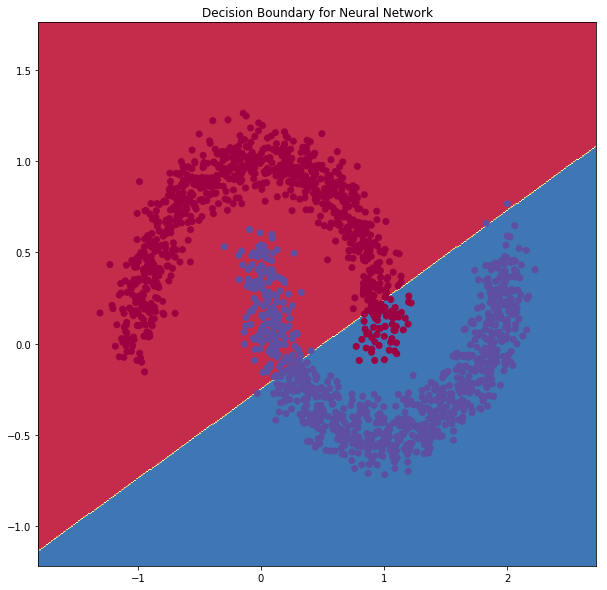

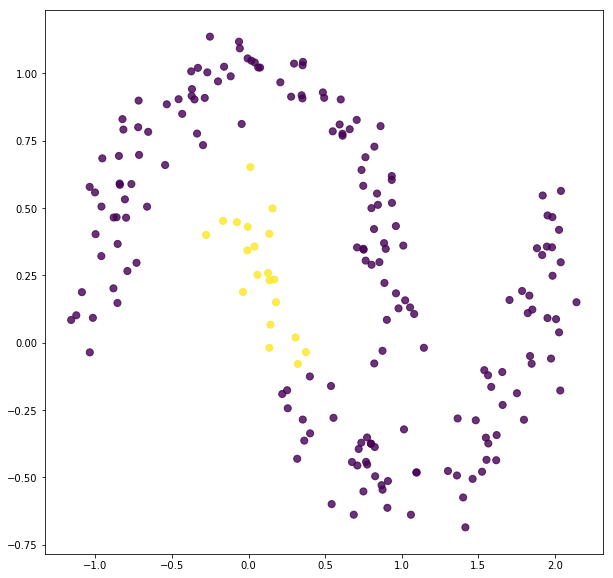

In [21]:
plt.figure(figsize=(10,10))
if output_mode == "Sigmoid":
    plot_decision_boundary(lambda x: np.around(forward_propagation(x, depth, weights, hidden_mode, output_mode)[depth - 1]), X, y)
    plt.title("Decision Boundary for Neural Network")
    plt.show()
if output_mode == "Softmax":
    plot_decision_boundary(lambda x: np.argmax(forward_propagation(x, depth, weights, hidden_mode, output_mode)[depth - 1],1), X, np.argmax(y,1))
    plt.title("Decision Boundary for Neural Network")
    plt.show()
if output_mode == "Linear":
    plot_function(lambda x: forward_propagation(x, depth, weights, hidden_mode, output_mode)[depth - 1], X, y)
    plt.title("Estimated Function")
    plt.show()

if output_mode == "Softmax":
    labels_flat = np.argmax(y_test, axis = 1)
    predictions = np.argmax(layer[depth - 1], axis = 1)
if output_mode == "Sigmoid":
    labels_flat = np.around(y_test).flatten()
    predictions = np.around(layer[depth - 1]).flatten()
if output_mode != "Linear":    
    plt.figure(figsize = (10, 10))
    plt.scatter(X_test[:, 0], X_test[:, 1], c = predictions == labels_flat - 1, alpha = .8, s = 50)
    plt.show()

### The Weight of the Neural Network

In [14]:
for i in range(len(weights)):
    print ("Hidden Weights of "+hidden_mode+" Activation Function for Layer "+str(i))
    print (weights[i])

Hidden Weights of Tangent Activation Function for Layer 0
[[ 0.00345509  0.31668848 -0.58502224 -0.18812276 -0.8655943  -0.37211762
  -0.50916504 -0.4966118  -0.06151097  0.47684261 -0.24265673  0.49029453
  -0.41766279  0.49793779 -0.71387519  0.74021264  0.40220635  0.19383282
  -0.57193148 -0.20419579  0.70913788  0.7834124  -0.24319625  0.41212044
   0.35810319]
 [ 0.401014   -1.00955232 -0.22593464 -0.31784264  0.64816806 -0.25940184
   0.04840543  0.5002358   0.27467644  0.65689684 -0.07225782  0.54434379
   0.32840805 -1.29312554  0.59077133  1.05475429  0.66408343 -0.31876531
   0.39404798 -0.36485907  0.40635236  0.97697448 -0.14784888  0.18517362
  -0.91669268]
 [-0.51060832  0.18966112 -0.42650979 -0.32656638 -0.23656986 -0.49789227
  -0.1212366  -0.53559365  0.05520022  0.33764657 -0.50036474 -0.07718137
   0.06663867 -0.12649294 -0.51722501  0.14985006  0.36073297 -0.0508317
   0.27426669 -0.0271878   0.61089923 -0.27962969 -0.46219831  0.43785762
  -0.19060607]]
Hidden We